**Neural networks for road segmentation**
========================

We will train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
#!pip install pytorch_lightning

In [2]:
import pytorch_lightning as pl
from typing import Dict, List, Tuple
import torch
from torch import nn

In [3]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import albumentations as A
import albumentations.pytorch

In [5]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):
        images_paths.append(os.path.join(path, filename))

    return np.stack(images_paths)

class RoadDataset(Dataset):
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        im_name = self.images[idx]
        mask_name = self.masks[idx]

        image = cv2.imread(im_name).astype('float32')[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE).astype('float32')
        mask = (mask > 0).astype(np.float32)

        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }

        if self.aug is not None:
            augmentations = self.aug(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = torch.unsqueeze(mask, 0)
        else:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = torch.unsqueeze(mask, 0)

        return image.float(), mask.float()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -q drive/MyDrive/data.zip -d data

In [36]:
X_train = get_paths("data/data/train/images")
y_train = get_paths("data/data/train/gt")

WIDTH, HEIGHT = 256, 256

# это трансформы для теста (без всяких аугментаций)
transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
    A.pytorch.transforms.ToTensorV2()
])

# а это для трейна 
aug = A.Compose([
    A.Resize(WIDTH, HEIGHT),
    # A.RandomCrop(width=WIDTH, height=HEIGHT),      пробовал еще с такими, но как-то не очень выходило
    # A.VerticalFlip(p=0.4),
    # A.GridDistortion(p=0.2),
    # A.GaussNoise(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(hue=.05, saturation=.05),
    A.Rotate(30),
    A.pytorch.transforms.ToTensorV2()
])

In [37]:
train_dataset = RoadDataset(X_train, y_train, transform, aug)

In [38]:
X_test = get_paths("data/data/test/images")
y_test = get_paths("data/data/test/gt")
test_dataset = RoadDataset(X_test, y_test, transform)

In [39]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=3
)

val_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=3
)

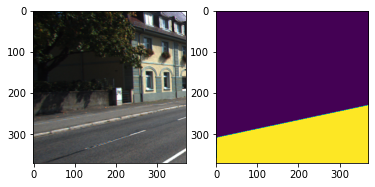

In [ ]:
image, mask = train_dataset[110]

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

In [ ]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so we will actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. We can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. There is also possible to try to use softIoU or DICE loss.

In [12]:
def calc_iou(prediction, ground_truth):
    prediction = prediction.detach().cpu().numpy()
    ground_truth = ground_truth.detach().cpu().numpy()
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [ ]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

Напишем свой UNET)

In [13]:
class ConvBlock(pl.LightningModule):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(pl.LightningModule):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [32, 64, 128],
        learning_rate: float = 1e-3,
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)  # Phase change
        for feature in features:
            self.down.append(ConvBlock(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(
                    in_channels=feature * 2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.up.append(
                ConvBlock(
                    in_channels=feature * 2, out_channels=feature
                )  # x gets concat to 2xchannel
            )
        self.bottleneck = ConvBlock(
            in_channels=features[-1], out_channels=features[-1] * 2
        )
        self.final_conv = nn.Conv2d(
            in_channels=features[0], out_channels=out_channels, kernel_size=1
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=0.3
        )

        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.val_iou = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0
        self.iou = 0
        self.validation_step_outputs = []
        self.train_step_outputs = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []  # storage for skip connections
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse list
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat(
                (skip_connection, x), dim=1
            )  # Concat along channels dimensions (b, c, h, w)
            x = self.up[idx + 1](concat_skip)
        return self.final_conv(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, batch: torch.Tensor, batch_idx) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
        self.iou += calc_iou(pred, y)
        self.train_step_outputs.append(loss)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_train_epoch_end(self):
        train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
        self.log("train_acc", train_acc, prog_bar=True)
        dice_score = self.dice_score / len(self.train_step_outputs)
        self.log("train_dice_score", dice_score, prog_bar=True)
        iou_score = self.iou / len(self.train_step_outputs)
        self.log("train_iou_score", iou_score, prog_bar=True)
        self.iou, self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0, 0
        self.train_step_outputs.clear()

    def validation_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.val_dice_score += (2 * (pred * y).sum()) / \
         ((pred + y).sum() + 1e-8)
        self.val_iou += calc_iou(pred, y)                     # ЗДЕСЬ СЧИТАЕТСЯ IoU ПО БАТЧУ
        self.validation_step_outputs.append(loss)
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_validation_epoch_end(self):
        val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
        self.log("val_acc", val_acc, prog_bar=True)
        dice_score = self.val_dice_score / len(self.validation_step_outputs)
        self.log("val_dice_score", dice_score, prog_bar=True)
        iou_score = self.val_iou / len(self.validation_step_outputs)           # А ЗДЕСЬ IoU УСРЕДНЯЕТСЯ И ЛОГИРУЕТСЯ
        self.log("val_iou_score", iou_score, prog_bar=True)
        self.val_iou, self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0, 0
        self.validation_step_outputs.clear()

In [ ]:
pl.utilities.model_summary.summarize(UNET(), -1)

   | Name              | Type              | Params
---------------------------------------------------------
0  | down              | ModuleList        | 287 K 
1  | down.0            | ConvBlock         | 10.2 K
2  | down.0.conv       | Sequential        | 10.2 K
3  | down.0.conv.0     | Conv2d            | 864   
4  | down.0.conv.1     | BatchNorm2d       | 64    
5  | down.0.conv.2     | ReLU              | 0     
6  | down.0.conv.3     | Conv2d            | 9.2 K 
7  | down.0.conv.4     | BatchNorm2d       | 64    
8  | down.0.conv.5     | ReLU              | 0     
9  | down.1            | ConvBlock         | 55.6 K
10 | down.1.conv       | Sequential        | 55.6 K
11 | down.1.conv.0     | Conv2d            | 18.4 K
12 | down.1.conv.1     | BatchNorm2d       | 128   
13 | down.1.conv.2     | ReLU              | 0     
14 | down.1.conv.3     | Conv2d            | 36.9 K
15 | down.1.conv.4     | BatchNorm2d       | 128   
16 | down.1.conv.5     | ReLU              | 0     
17 | d

Если открывать в юпитере тетрадку, которая была запущена в колабе, то лайтнинговые логи не отображаются, поэтому я прикрепляю скрины из колаба

In [ ]:
model = UNET()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


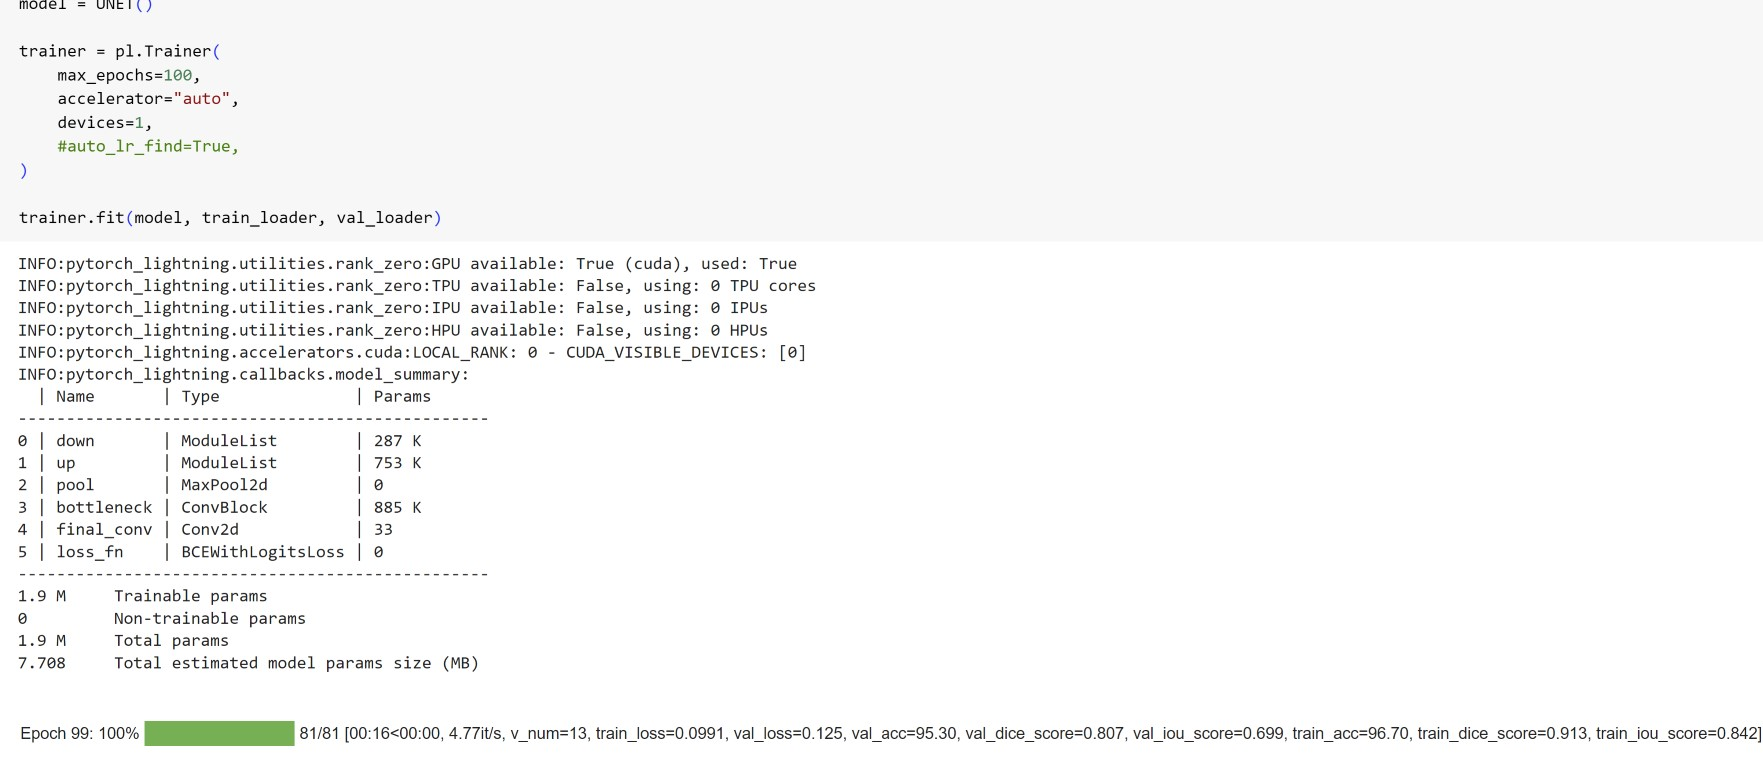

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'UNET')
files.download('UNET')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Пока недостаточно - IoU 0.7, пробуем уменьшить шаг и обучить еще

In [ ]:
model = UNET()
model.load_state_dict(torch.load('UNET'))

<All keys matched successfully>

In [ ]:
for param in model.optimizer.param_groups:
  param['lr'] = 0.0003

In [ ]:
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


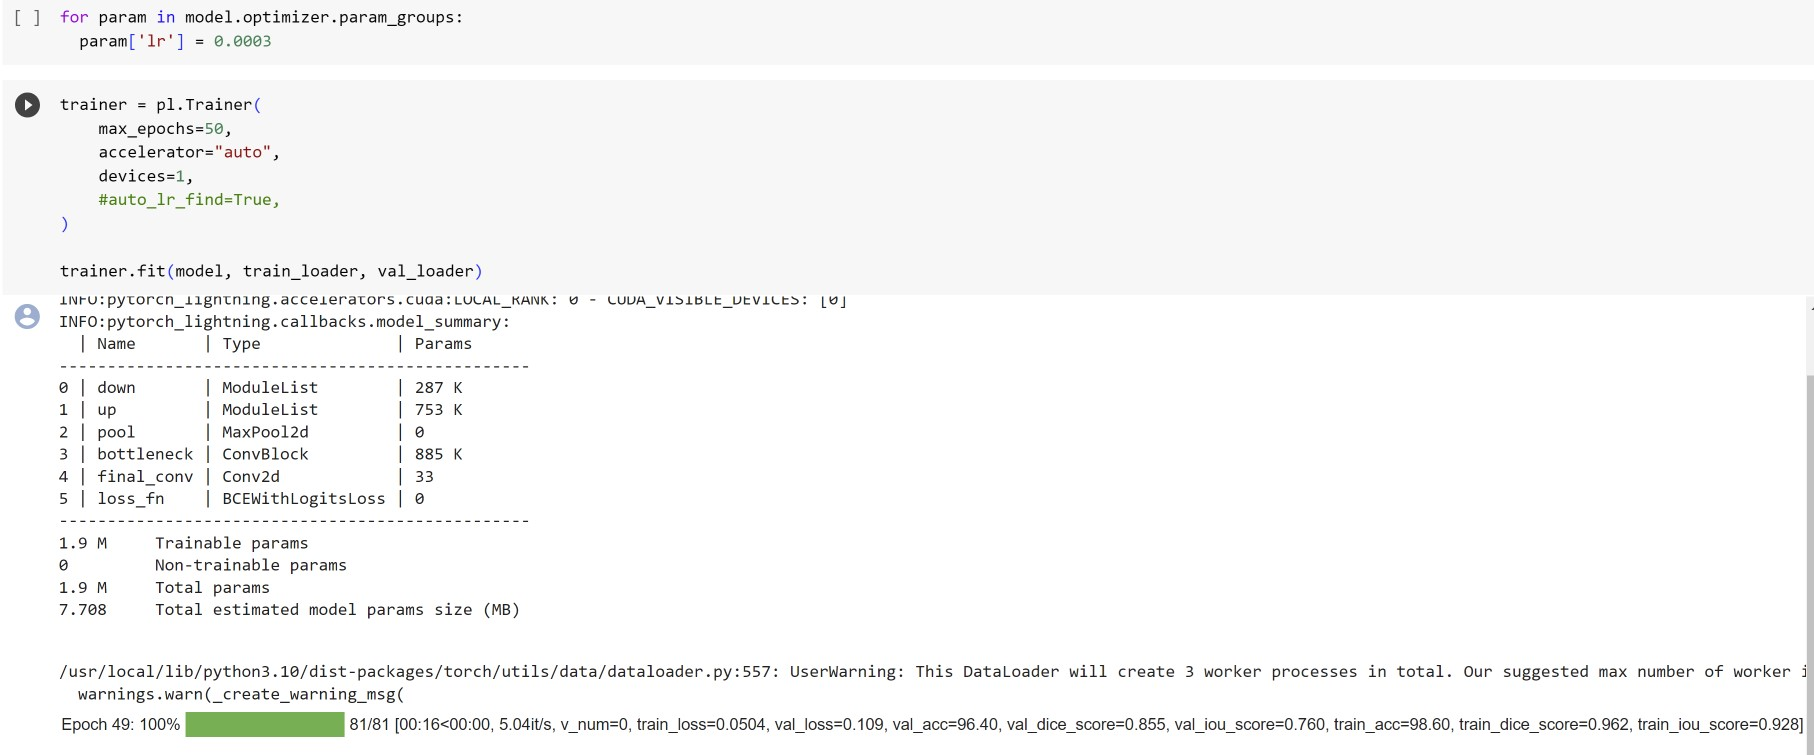

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'UNET1')
files.download('UNET1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Отлично, порог побит - IoU = 0.76 , может даже приблизимся к следующему?)

In [ ]:
for param in model.optimizer.param_groups:
  param['lr'] = 0.00005

In [ ]:
trainer = pl.Trainer(
    max_epochs=70,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=70` reached.


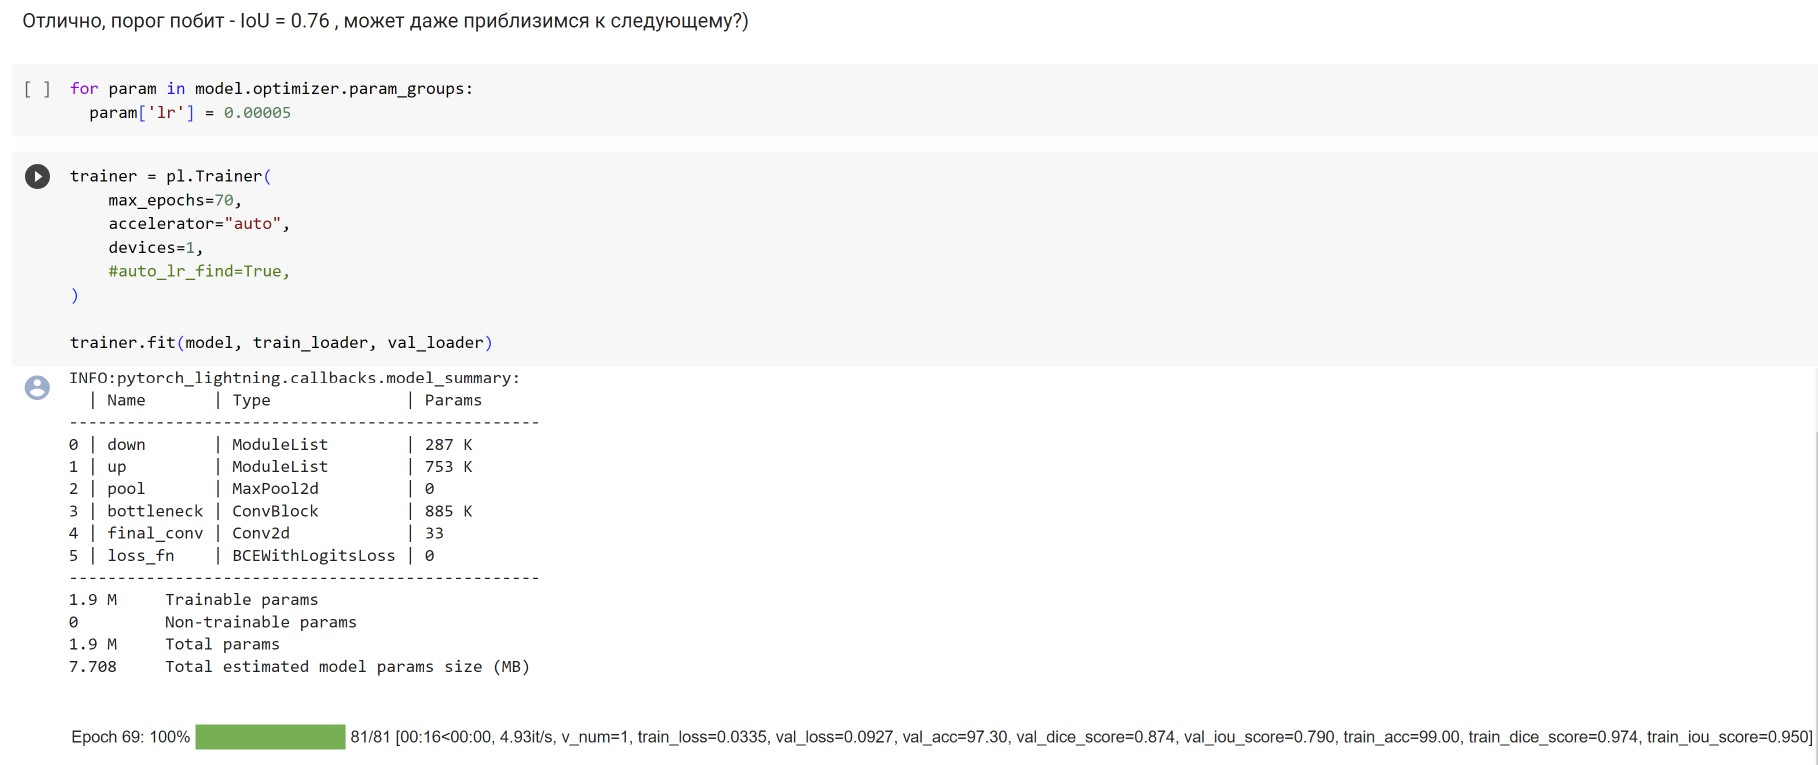

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'UNET2')
files.download('UNET2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ну, до 0.87 далеко - IoU = 0.790, но вообще качество отличное - переходим к следующему

Теперь возьмем pretrained модель и дообучим ее на нашей задаче

In [2]:
#!pip install segmentation_models_pytorch

In [15]:
import segmentation_models_pytorch as smp

In [16]:
resnet50 = smp.Unet('resnet50', encoder_weights='imagenet', classes=1, activation=None,
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [40]:
class PretrainedUNET(pl.LightningModule):
    def __init__(
        self,
        net = resnet50,
        learning_rate: float = 2e-4,
    ):
        super().__init__()
        self.net = net
        self.learning_rate = learning_rate
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=0.3
        )

        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.val_iou = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0
        self.iou = 0
        self.validation_step_outputs = []
        self.train_step_outputs = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, batch: torch.Tensor, batch_idx) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
        self.iou += calc_iou(pred, y)
        self.train_step_outputs.append(loss)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_train_epoch_end(self):
        train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
        self.log("train_acc", train_acc, prog_bar=True)
        dice_score = self.dice_score / len(self.train_step_outputs)
        self.log("train_dice_score", dice_score, prog_bar=True)
        iou_score = self.iou / len(self.train_step_outputs)
        self.log("train_iou_score", iou_score, prog_bar=True)
        self.iou, self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0, 0
        self.train_step_outputs.clear()

    def validation_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.val_dice_score += (2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8)
        self.val_iou += calc_iou(pred, y)
        self.validation_step_outputs.append(loss)
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss}

    def on_validation_epoch_end(self):
        val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
        self.log("val_acc", val_acc, prog_bar=True)
        dice_score = self.val_dice_score / len(self.validation_step_outputs)
        self.log("val_dice_score", dice_score, prog_bar=True)
        iou_score = self.val_iou / len(self.validation_step_outputs)
        self.log("val_iou_score", iou_score, prog_bar=True)
        self.val_iou, self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0, 0
        self.validation_step_outputs.clear()

In [ ]:
pretrained_model = PretrainedUNET()

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(pretrained_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params
----------------------------------------------
0 | net     | Unet              | 32.5 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


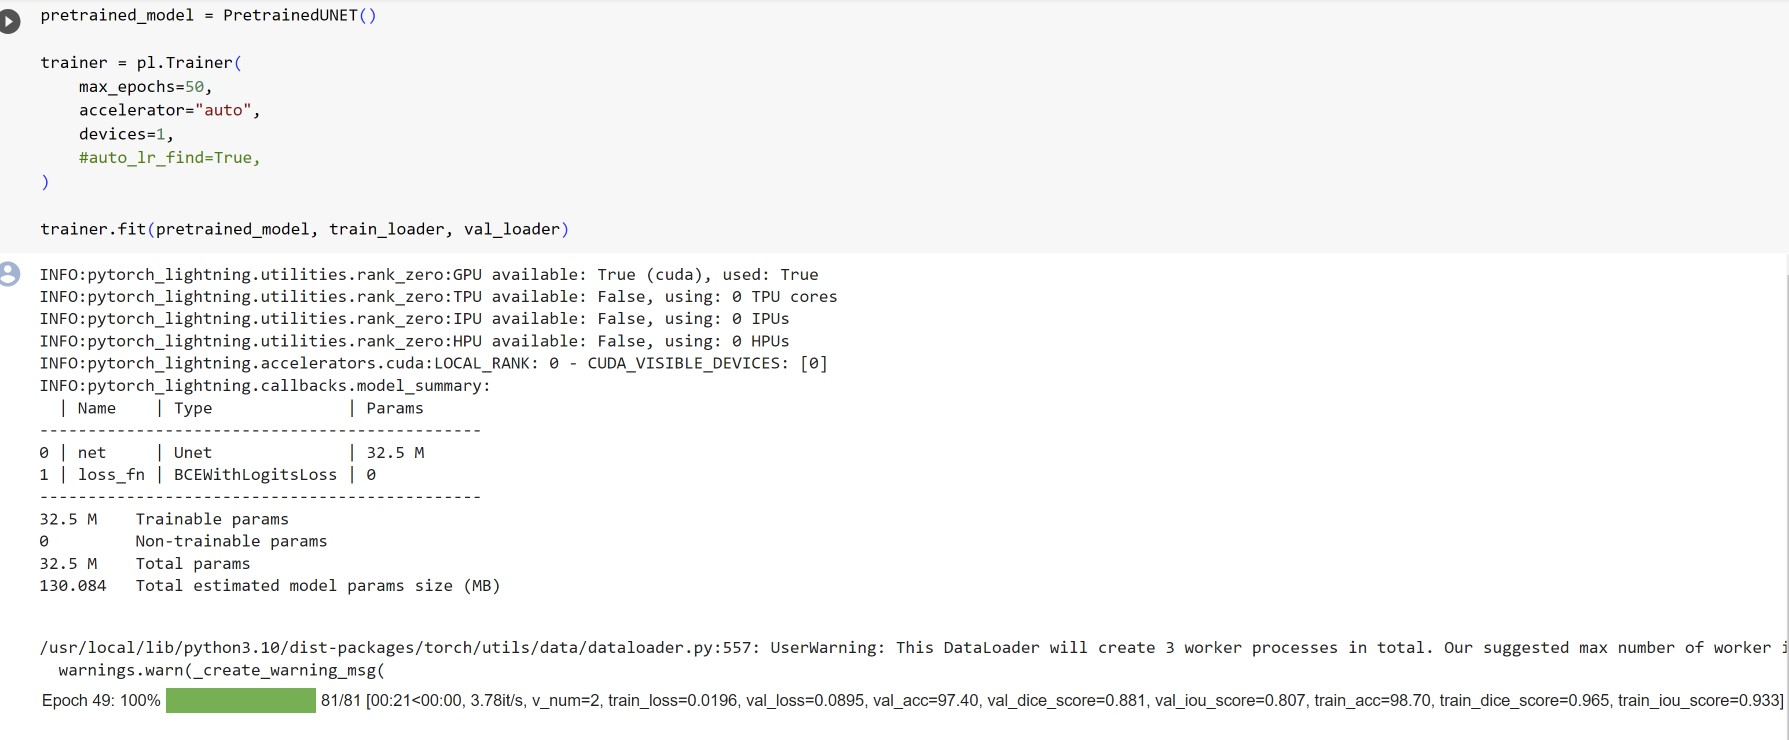

ResNet50 недотянул - IoU = 0.807, попробуем модель потяжелее

In [ ]:
pretrained_model = PretrainedUNET(net=smp.Unet('efficientnet-b7', encoder_weights='imagenet', classes=1, activation=None,
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]), learning_rate=7e-4)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(pretrained_model, train_loader, val_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:05<00:00, 50.1MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params
----------------------------------------------
0 | net     | Unet              | 67.1 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.381   Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


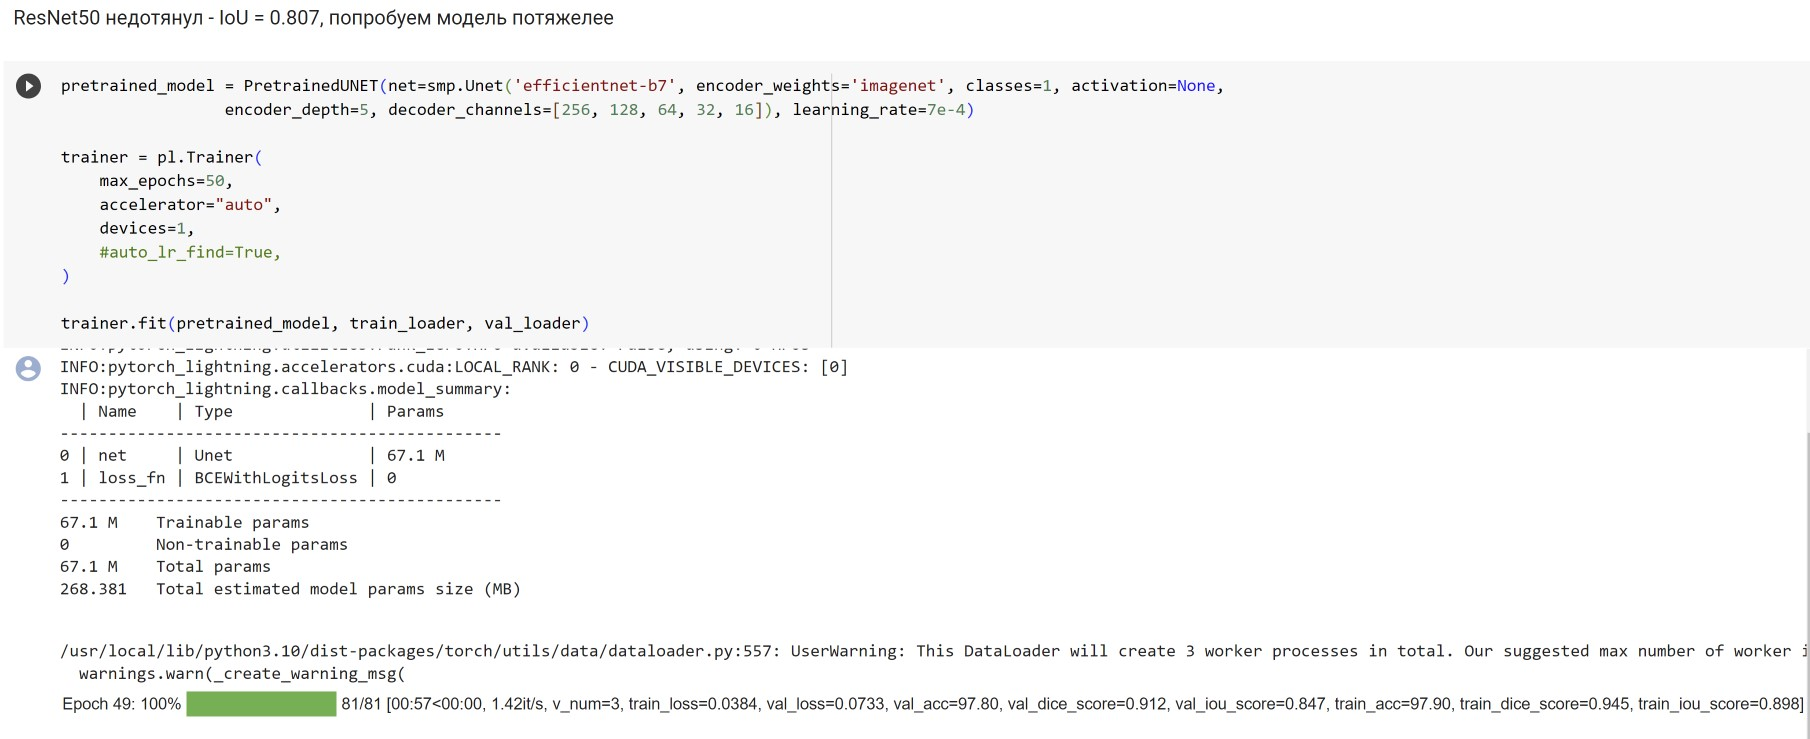

Тут шансы есть - IoU = 0.847, попробуем еще обучить с меньшим шагом

In [ ]:
from google.colab import files

torch.save(pretrained_model.state_dict(), 'pretrained_UNET')
files.download('pretrained_UNET')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Тут я прерывался, поэтому надо подгрузить последнее сохранение

In [41]:
pretrained_model = PretrainedUNET(net=smp.Unet('efficientnet-b7', encoder_weights='imagenet', classes=1, activation=None,
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]), learning_rate=5e-5)

pretrained_model.load_state_dict(torch.load('drive/MyDrive/pretrained_UNET'))

<All keys matched successfully>

Выставляем шаг поменьше, чтобы получше сойтись

In [42]:
for param in pretrained_model.optimizer.param_groups:
  param['lr'] = 5e-5

In [43]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1,
    #auto_lr_find=True,
)

trainer.fit(pretrained_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params
----------------------------------------------
0 | net     | Unet              | 67.1 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.381   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


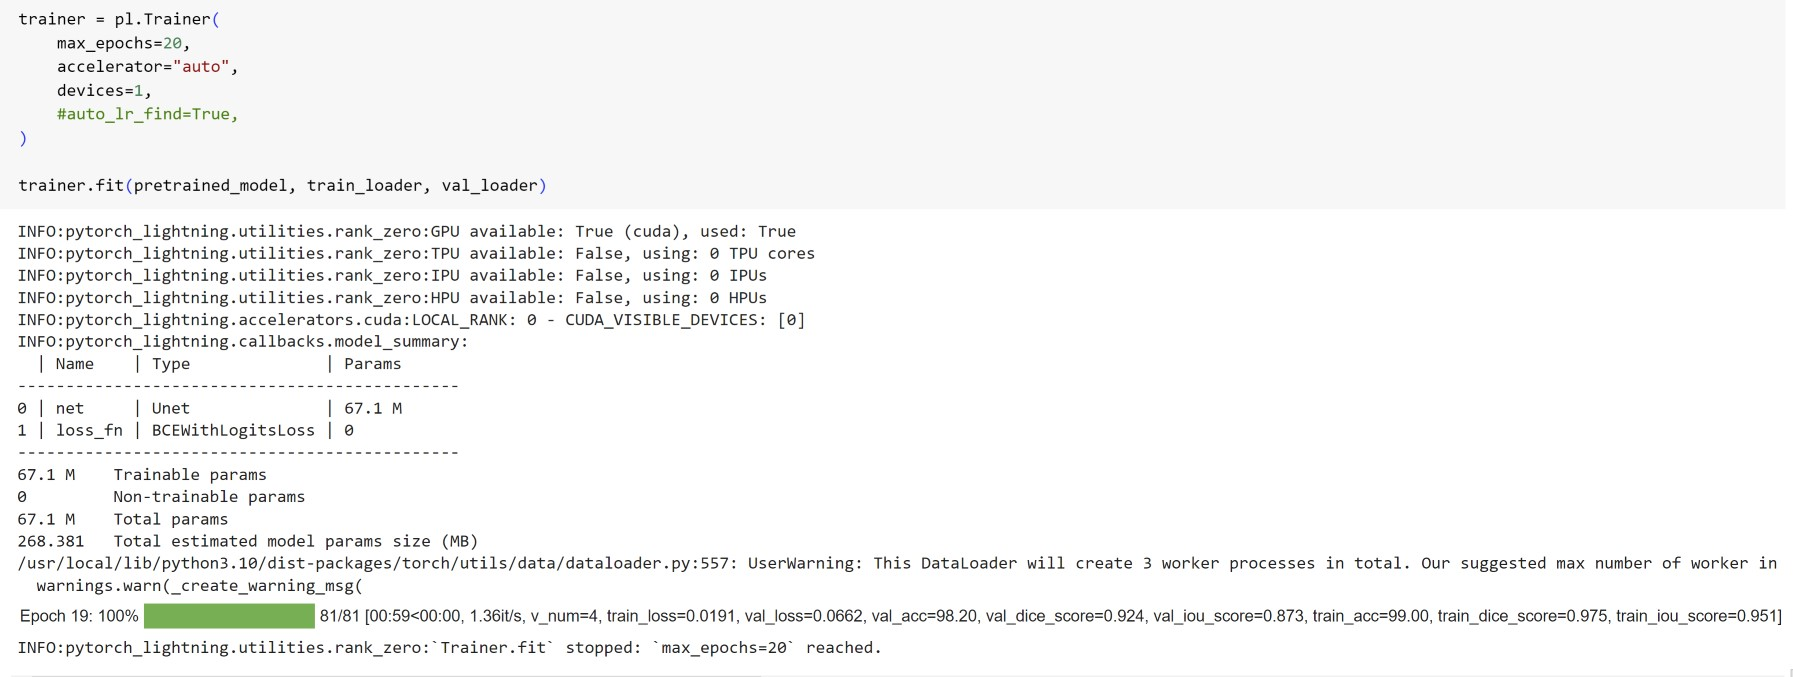

Ура, IoU score 0.873, а это значит, что бейзлайн побит :)